# Pretrained word embeddings - GloVe 

In [1]:
import numpy as np
import pandas as pd
import os, re, codecs

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, GRU
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Parsing the GloVe word-embeddings file

In [2]:
glove_dir = '.'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Load data

In [3]:
data_dir = "../dlnn/datasets"

In [4]:
df = pd.read_csv(os.path.join(data_dir, "df_final.csv"))

### Tokenizing the data

In [5]:
maxwords = 100000

In [6]:
df_X = df["comment_text"]
df_Y = df["target_dis"]

In [7]:
df['doc_len'] = df['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
max_seq_len = 80 # Hard-coded: changed from 100 to 80

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.8)

In [9]:
tokenizer = Tokenizer(num_words = maxwords)# Creates a tokenizer, configured to only take into account the 1,000 most common words
tokenizer.fit_on_texts(df_X)# Builds the word index

X_train = tokenizer.texts_to_sequences(X_train)# Turn strings into lists of integer indices
X_test = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  302139


In [10]:
X_train = pad_sequences(X_train, padding='post', maxlen=max_seq_len)# Turns the lists of integers into a 2D tensor of shape (samples, maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=max_seq_len)

### Training and model parameters

In [11]:
# Training params
batch_size = 64
epochs = 4

# Model parameters
# Convolution
num_filters = 64
kernel_size = 7
embed_dim = 100
weight_decay = 1e-4
pool_size = 4

# LSTM
lstm_output_size = 100

### Preparing the GloVe word-embeddings matrix

In [12]:
print('Preparing embedding matrix...')

words_not_found = []
nb_words = min(maxwords, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
        
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Preparing embedding matrix...
number of null word embeddings: 29048


In [13]:
embedding_matrix.shape

(100000, 100)

In [14]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['intolerent' "remembrance'" 'antifederalist' 'makeharperpay' "chicago's"
 'hense' 'timesharescam' "'whole'" 'thought”' 'pipeliners']


In [15]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [ 0.08102   , -0.86128002, -0.016348  , ...,  0.22133   ,
         0.078387  , -0.28375   ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.91210997,  0.19836999, -0.28896999, ...,  0.0389    ,
        -0.41701001,  0.2773    ]])

### Custom metrics:  f1_score, precision, recall

In [16]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Defining and training a model

In [17]:
inputs = tf.keras.layers.Input(shape=(max_seq_len,))
x = tf.keras.layers.Embedding(input_dim=nb_words, output_dim=embed_dim, weights=[embedding_matrix], trainable=False)(inputs)
x = tf.keras.layers.LSTM(100)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

adam = tf.keras.optimizers.Adam(lr=0.0003, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc', f1_m, precision_m, recall_m])

# Callbacks
checkpoint_path = "./GloVe_train/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

    # tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    
callbacks = [
    cp_callback
]

hist = model.fit(X_train, y_train, batch_size=128, epochs=20, callbacks=callbacks, validation_split=0.2, shuffle=True, verbose=2)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 100)           10000000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 10,080,50

In [18]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

In [24]:
f1_score

0.6887274

In [25]:
accuracy

0.701253

In [26]:
loss

0.5748324682609659

### Save whatever model

In [19]:
model.save("CNN_FastText.h5")
print("Saved model to disk")

Saved model to disk


### Plot model results

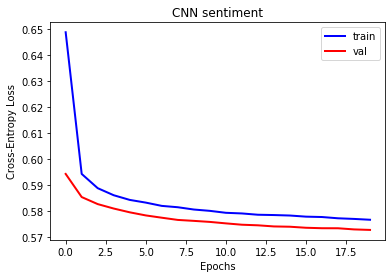

In [23]:
import matplotlib.pyplot as plt

#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

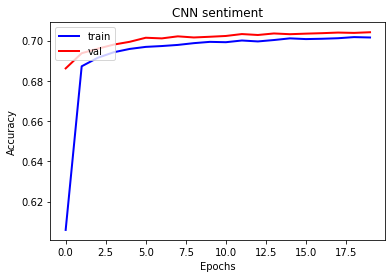

In [21]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='upper left')
plt.show()

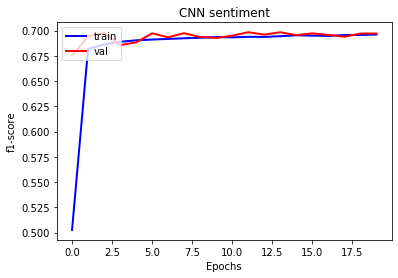

In [22]:
plt.figure()
plt.plot(hist.history['f1_m'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_f1_m'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend(loc='upper left')
plt.show()